# Explore here

## Step 1: Problem statement and data collection

Problem statement: Based on other known features about a customer, use ML to determine whether that customer will take out a long-term deposit or not (categorical)

In [1]:
# Import dataset to start working with it
import pandas as pd

raw_data = pd.read_csv("../data/raw/bank-marketing-campaign-data.csv", sep=";")


## Step 2: Exploration and data cleaning

In [2]:
print(f"Raw data shape: {raw_data.shape}")
print(raw_data.info())

Raw data shape: (41188, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  con

Unlike prior exercise, doesn't look as though any of our columns have missing data at all, which simplifies matters.

I don't see a column for ID in here, and the rest of the data points seem generic enough that it's plausible to me we'd have multiple identical-seeming rows sourced from separate actual people, so am skipping the duplicate-finding-and-dropping step we did for our previous EDA.

In [3]:
print(raw_data.shape)
raw_data.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
# remove data considered irrelevant
# raw_data.drop(
#    ["id", "name", "host_name", "last_review", "reviews_per_month"],
#    axis=1,
#    inplace=True,
# )
# skipping this because as of yet, none of the columns in the raw dataset look strictly-irrelevant to me


raw_data.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Step 3: Analysis of univariate variables
### categorical variables
Categorical, non-numeric variables in this dataframe include: job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome

All of these are plausible to me as relevant.

In [5]:
categorical_variables = [
    "job",
    "marital",
    "education",
    "default",
    "housing",
    "loan",
    "contact",
    "month",
    "day_of_week",
    "poutcome",
]

for each_categorical_variable in categorical_variables:
    print(f"\n\t{each_categorical_variable}s:")
    for each_possible_value in sorted(
        raw_data[f"{each_categorical_variable}"].unique()
    ):
        print(each_possible_value)


	jobs:
admin.
blue-collar
entrepreneur
housemaid
management
retired
self-employed
services
student
technician
unemployed
unknown

	maritals:
divorced
married
single
unknown

	educations:
basic.4y
basic.6y
basic.9y
high.school
illiterate
professional.course
university.degree
unknown

	defaults:
no
unknown
yes

	housings:
no
unknown
yes

	loans:
no
unknown
yes

	contacts:
cellular
telephone

	months:
apr
aug
dec
jul
jun
mar
may
nov
oct
sep

	day_of_weeks:
fri
mon
thu
tue
wed

	poutcomes:
failure
nonexistent
success


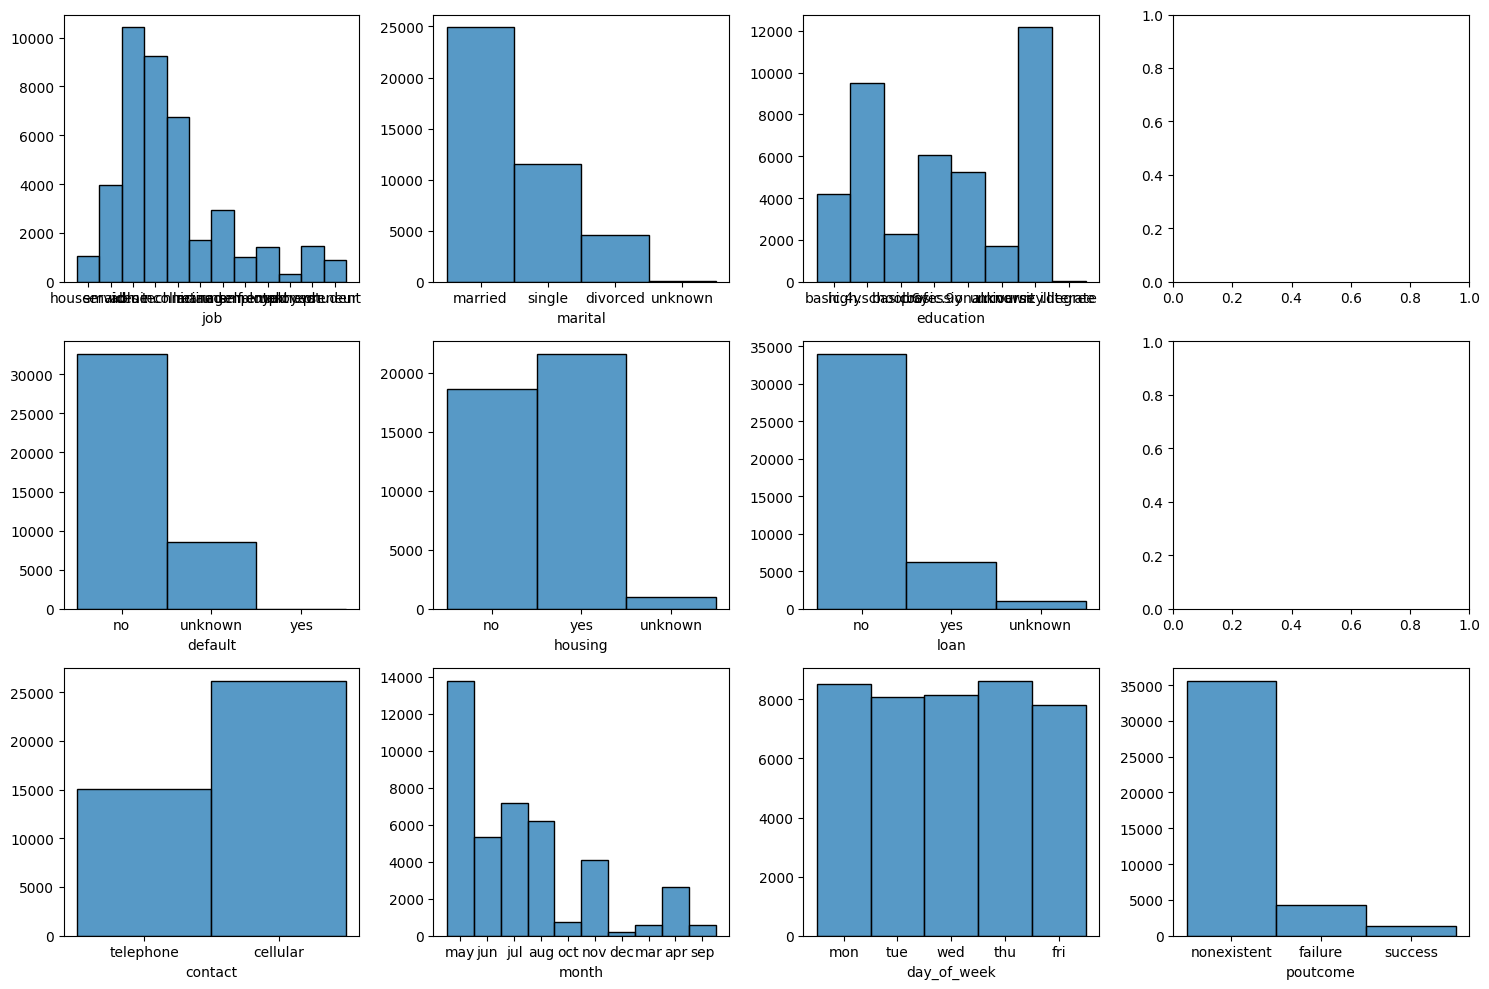

In [6]:
# histogram-plot each categorical variable

import matplotlib.pyplot as plt
import seaborn as sns

fig, axis = plt.subplots(3, 4, figsize=(15, 10))

# Create a multiple histogram
sns.histplot(ax=axis[0, 0], data=raw_data, x="job").set(ylabel=None)
sns.histplot(ax=axis[0, 1], data=raw_data, x="marital").set(ylabel=None)
sns.histplot(ax=axis[0, 2], data=raw_data, x="education").set(ylabel=None)

sns.histplot(ax=axis[1, 0], data=raw_data, x="default").set(ylabel=None)
sns.histplot(ax=axis[1, 1], data=raw_data, x="housing").set(ylabel=None)
sns.histplot(ax=axis[1, 2], data=raw_data, x="loan").set(ylabel=None)

sns.histplot(ax=axis[2, 0], data=raw_data, x="contact").set(ylabel=None)
sns.histplot(ax=axis[2, 1], data=raw_data, x="month").set(ylabel=None)
sns.histplot(ax=axis[2, 2], data=raw_data, x="day_of_week").set(ylabel=None)
sns.histplot(ax=axis[2, 3], data=raw_data, x="poutcome").set(ylabel=None)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

- seems like no phone campaigning happens in the first couple months of the year
- Most prospective customers were married, not in default, and didn't have a personal loan
- am now realizing that rather than having missing, null, NaN data in various columns, we have some with "unknown" instead.

### numeric variables

Numerical, non-categorical variables in the dataset include: age, duration, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed

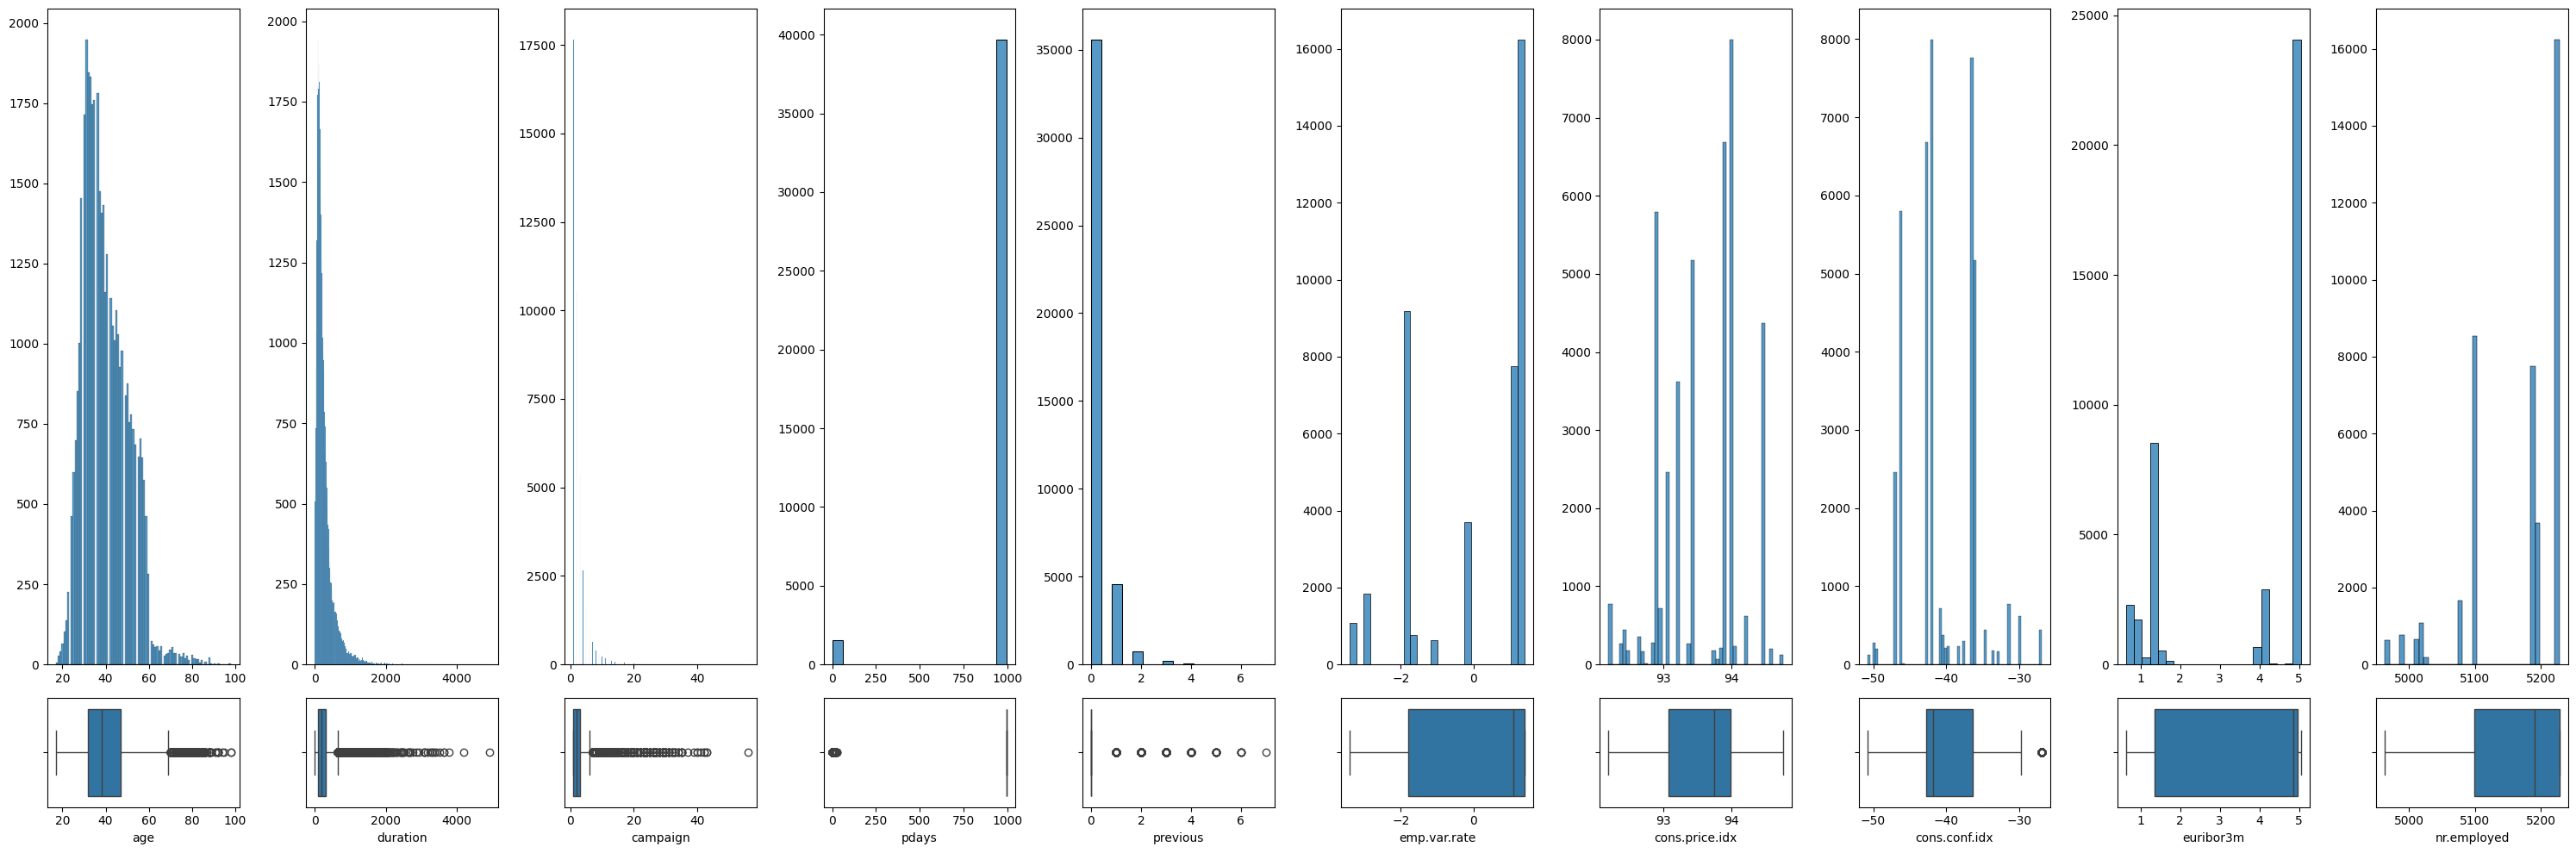

In [7]:
numeric_variables = [
    "age",
    "duration",
    "campaign",
    "pdays",
    "previous",
    "emp.var.rate",
    "cons.price.idx",
    "cons.conf.idx",
    "euribor3m",
    "nr.employed",
]
fig, axis = plt.subplots(
    2, len(numeric_variables), figsize=(30, 10), gridspec_kw={"height_ratios": [6, 1]}
)

# Creating a multiple figure with histograms and box plots
temp_column_index = 0
for each_numeric_variable in numeric_variables:
    sns.histplot(
        ax=axis[0, temp_column_index], data=raw_data, x=f"{each_numeric_variable}"
    ).set(xlabel=None, ylabel=None)
    sns.boxplot(
        ax=axis[1, temp_column_index], data=raw_data, x=f"{each_numeric_variable}"
    )
    temp_column_index += 1

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


From this it looks like:
- most people were contacted only one or few times in prior campaign, but some outliers look like they were pestered as many as 10, 20, 40 times or more
- Most contacts got off the phone within a few hundred seconds, but a much lesser quantity of calls could last a quarter-hour, half hour, or over an hour. (Will be intresting to see how that corresponds to them having taken out a long-term account).

## Step 4: Analysis of multivariate variables
### Numerical-numerical analysis
Am curious to see whether/how there are correlations between age & how long people stayed on the phone, or age & how many employees they have.


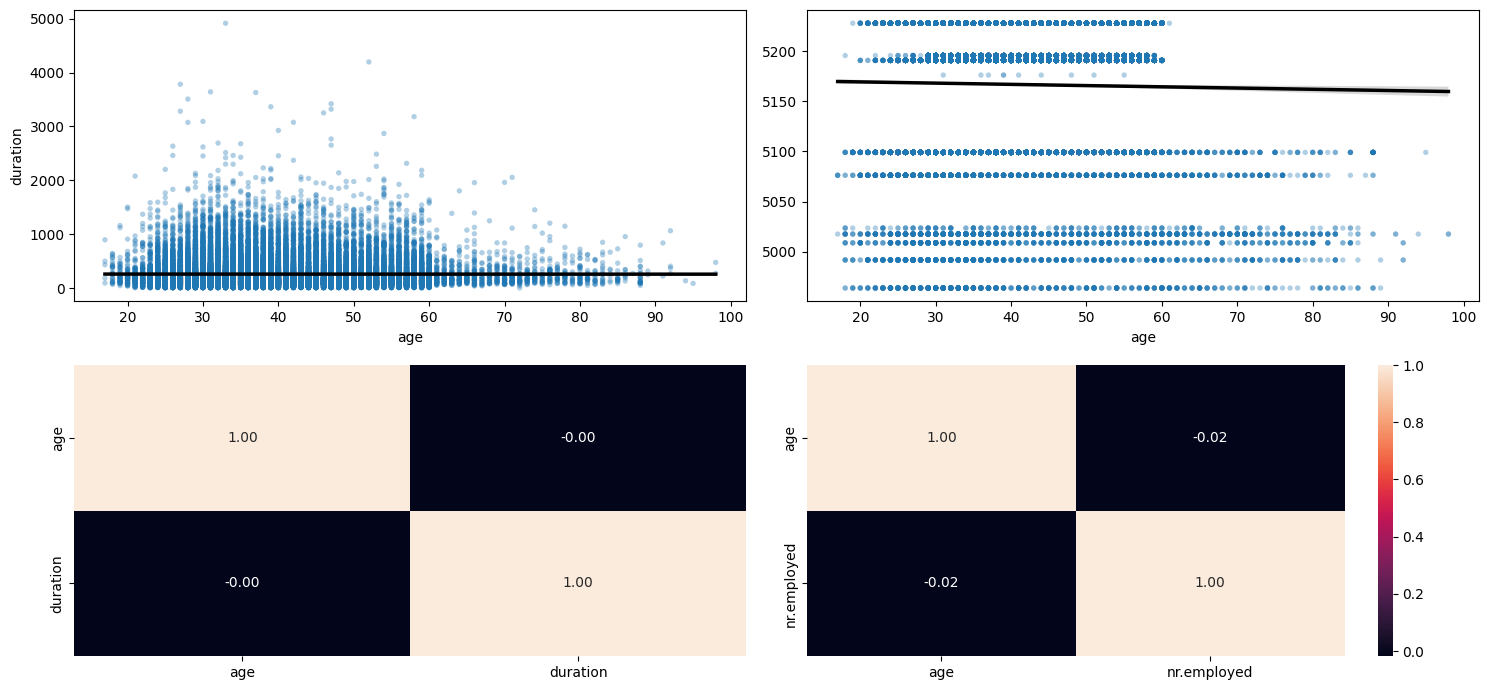

In [8]:
fig, axis = plt.subplots(2, 2, figsize=(15, 7))

# Create a multiple scatter diagram
common_scatter = {"s": 15, "alpha": 0.35, "edgecolor": "none"}
common_line = {"color": "black", "lw": 2.5, "zorder": 5}

sns.regplot(
    ax=axis[0, 0],
    data=raw_data,
    x="age",
    y="duration",
    scatter_kws=common_scatter,
    line_kws=common_line,
)
sns.heatmap(
    raw_data[["age", "duration"]].corr(),
    annot=True,
    fmt=".2f",
    ax=axis[1, 0],
    cbar=False,
)

sns.regplot(
    ax=axis[0, 1],
    data=raw_data,
    x="age",
    y="nr.employed",
    scatter_kws=common_scatter,
    line_kws=common_line,
).set(ylabel=None)
sns.heatmap(
    raw_data[["age", "nr.employed"]].corr(),
    annot=True,
    fmt=".2f",
    ax=axis[1, 1],
)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

Based on this it looks like there's no direct correlation between age and how long a prospect stayed on the phone.
There's a negative correlation (very slight, -0.02) whereby an older prospect has fewer employees, not more, which is opposite what I would've guessed.

### categorical-categorical analysis

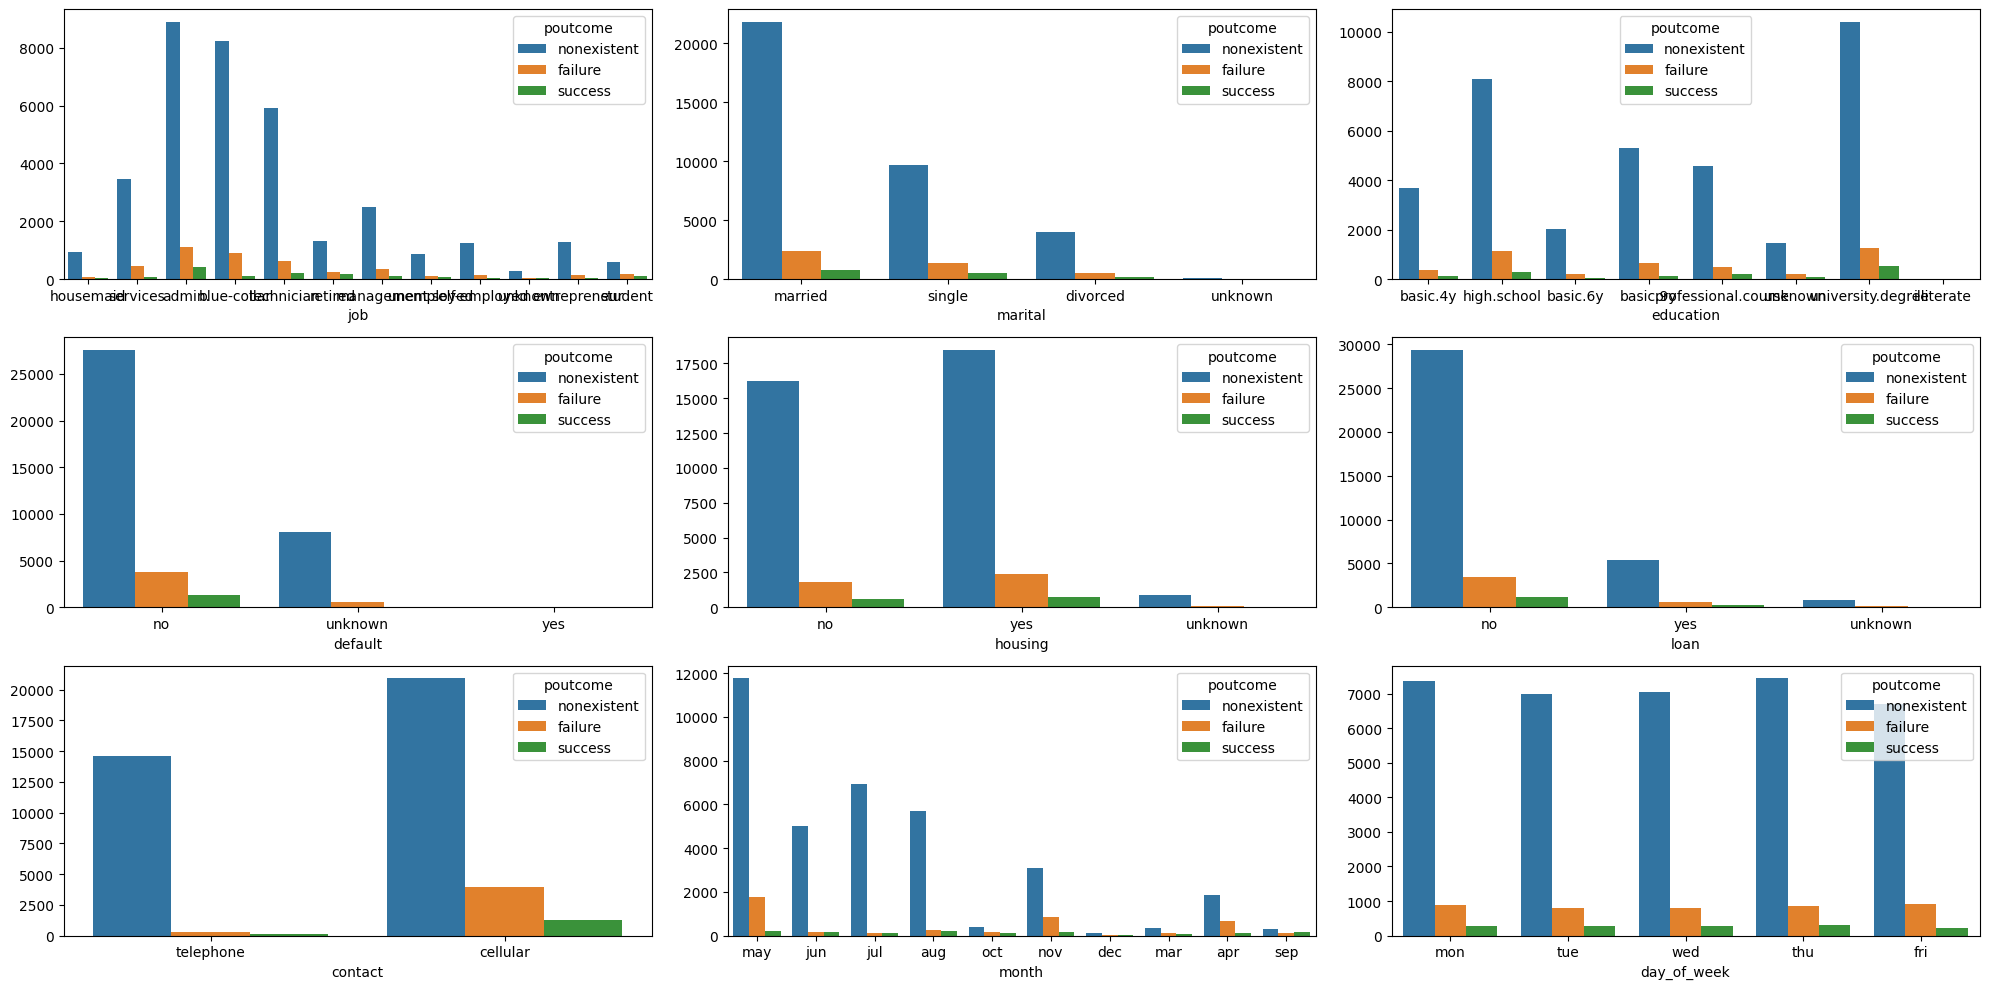

In [9]:
temp_categorical_variables = categorical_variables.copy()  # to avoid wrecking original copy when loop below starts popping them off the front as though a FIFO queue
fig, axis = plt.subplots(3, 3, figsize=(20, 10))

for row in range(3):
    for col in range(3):
        sns.countplot(
            ax=axis[row, col],
            data=raw_data,
            x=temp_categorical_variables[0],
            hue="poutcome",
        ).set(ylabel=None)
        temp_categorical_variables.remove(temp_categorical_variables[0])


plt.tight_layout()

plt.show()


#### Correlation analysis


['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']


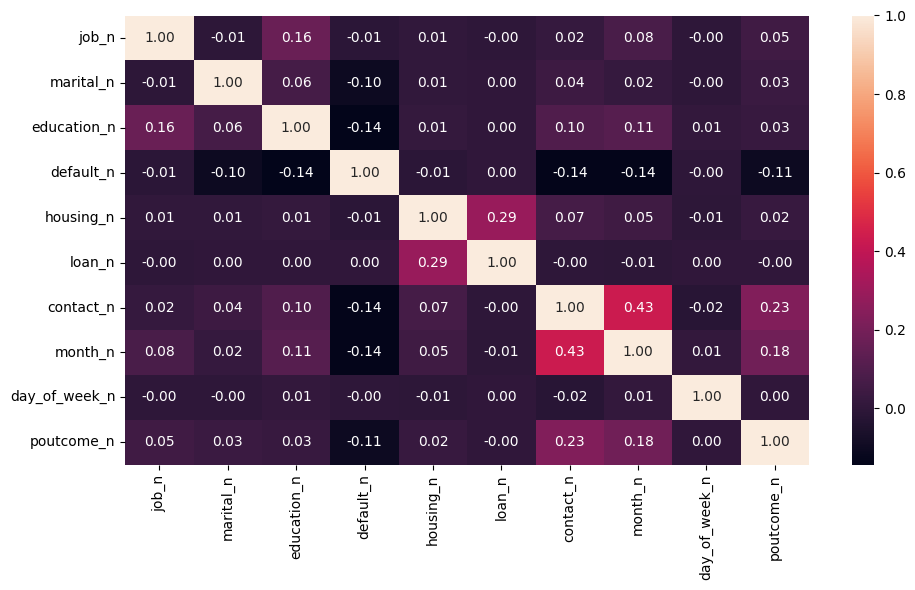

In [10]:
print(categorical_variables)
raw_data["job_n"] = pd.factorize(raw_data["job"])[0]
raw_data["marital_n"] = pd.factorize(raw_data["marital"])[0]
raw_data["education_n"] = pd.factorize(raw_data["education"])[0]
raw_data["default_n"] = pd.factorize(raw_data["default"])[0]
raw_data["housing_n"] = pd.factorize(raw_data["housing"])[0]
raw_data["loan_n"] = pd.factorize(raw_data["loan"])[0]
raw_data["contact_n"] = pd.factorize(raw_data["contact"])[0]
raw_data["month_n"] = pd.factorize(raw_data["month"])[0]
raw_data["day_of_week_n"] = pd.factorize(raw_data["day_of_week"])[0]
raw_data["poutcome_n"] = pd.factorize(raw_data["poutcome"])[0]


fig, axis = plt.subplots(figsize=(10, 6))

sns.heatmap(
    raw_data[
        [
            "job_n",
            "marital_n",
            "education_n",
            "default_n",
            "housing_n",
            "loan_n",
            "contact_n",
            "month_n",
            "day_of_week_n",
            "poutcome_n",
        ]
    ].corr(),
    annot=True,
    fmt=".2f",
)

plt.tight_layout()

plt.show()

Based on the negative-number correlations between default_n and plenty of other variables, seems like unmarried, uneducated people are both less likely to get called and less likely to take out a long-term account.
Looks like the strongest correlation is between the type of contact and when they were last contacted (i.e. I'd expect at least one of the months to have been a major burst of a certain type of contact).
Next strongest correlation is between whether the prospect did or did not simultaneously have both a personal loan and a housing loan; if they had either, they were more likely to have both, and/or if they didn't have either, more likely to have neither.
Based on the relatively-stronger correlations of poutcome and the contact type & month, looks like it'll be worth checking what was tried during certain months to have a greater influence on outcome.

### numerical-categorical analysis

KeyError: "None of [Index(['host_id', 'neighbourhood_group_n', 'neighbourhood_n', 'room_type_n',\n       'minimum_nights', 'number_of_reviews', 'calculated_host_listings_count',\n       'availability_365', 'price'],\n      dtype='object')] are in the [columns]"

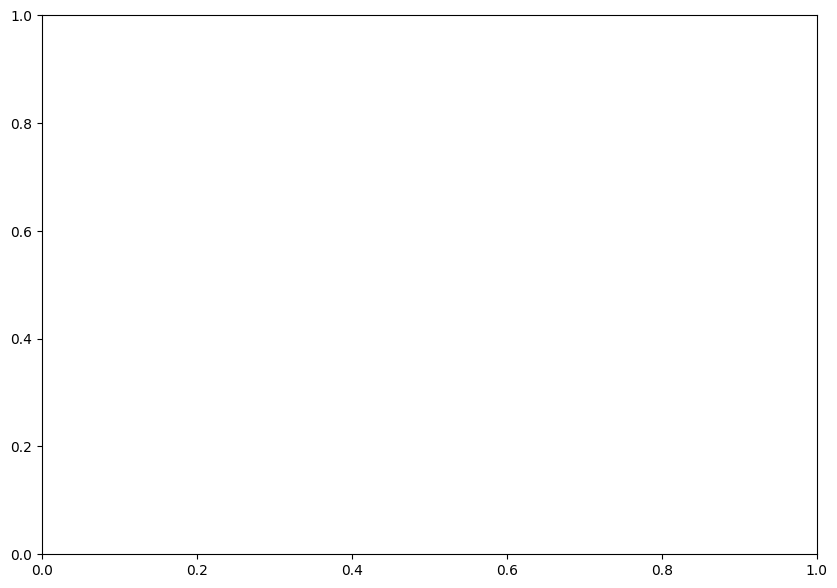

In [11]:
fig, axis = plt.subplots(figsize=(10, 7))

sns.heatmap(
    raw_data[
        [
            "host_id",
            "neighbourhood_group_n",
            "neighbourhood_n",
            "room_type_n",
            "minimum_nights",
            "number_of_reviews",
            "calculated_host_listings_count",
            "availability_365",
            "price",
        ]
    ].corr(),
    annot=True,
    fmt=".2f",
)

plt.tight_layout()

plt.show()

Based on the above, I'd assess:
- the strongest determinant of price is room type, rather than location; neighborhood location has a surprising-to-me lack of influence on price
- the strongest determinants of room availability (proportionally throughout the year) are who's hosting it (some people appear more ready/willing/able to host than others), and to a slightly-lesser but still notable extent, neighborhood.
- more-available rooms tended to get booked more times (not surprising) and to a slightly leser but still-noticeable extent, tended to get more reviewed.

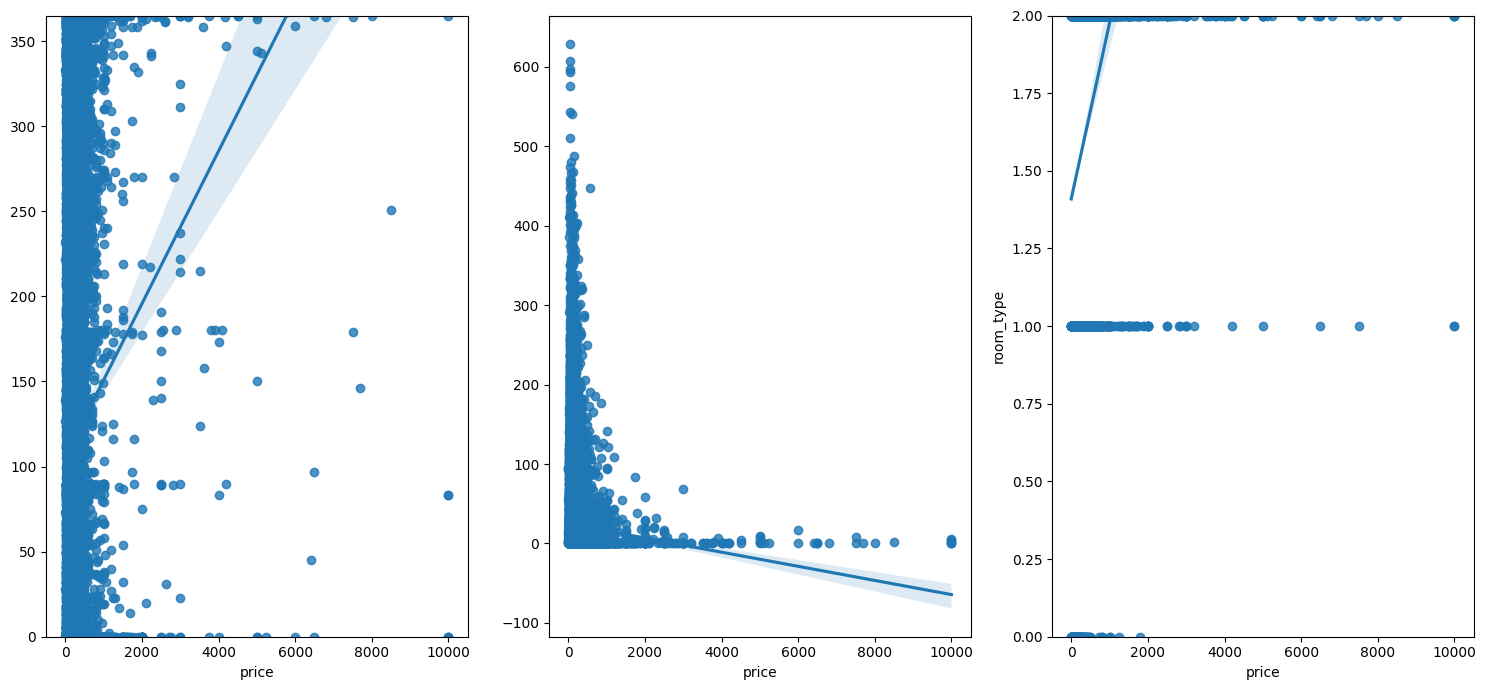

In [ ]:
fig, axis = plt.subplots(figsize=(15, 7), ncols=3)

sns.regplot(ax=axis[0], data=raw_data, x="price", y="availability_365").set(
    ylabel=None, ylim=(0, 365)
)
sns.regplot(ax=axis[1], data=raw_data, x="price", y="number_of_reviews").set(
    ylabel=None
)
sns.regplot(ax=axis[2], data=raw_data, x="price", y="room_type_n").set(
    ylabel="room_type", ylim=(0, 2)
)

plt.tight_layout()

plt.show()

Based on these regression plots:
- higher-cost listings tend to be available for more days of the year than lower-cost listings
- lower-cost listings tend to have more reviews written about them
- higher-end room types (e.g. whole-home instead of shared room) unsurprisingly tend to be higher-priced

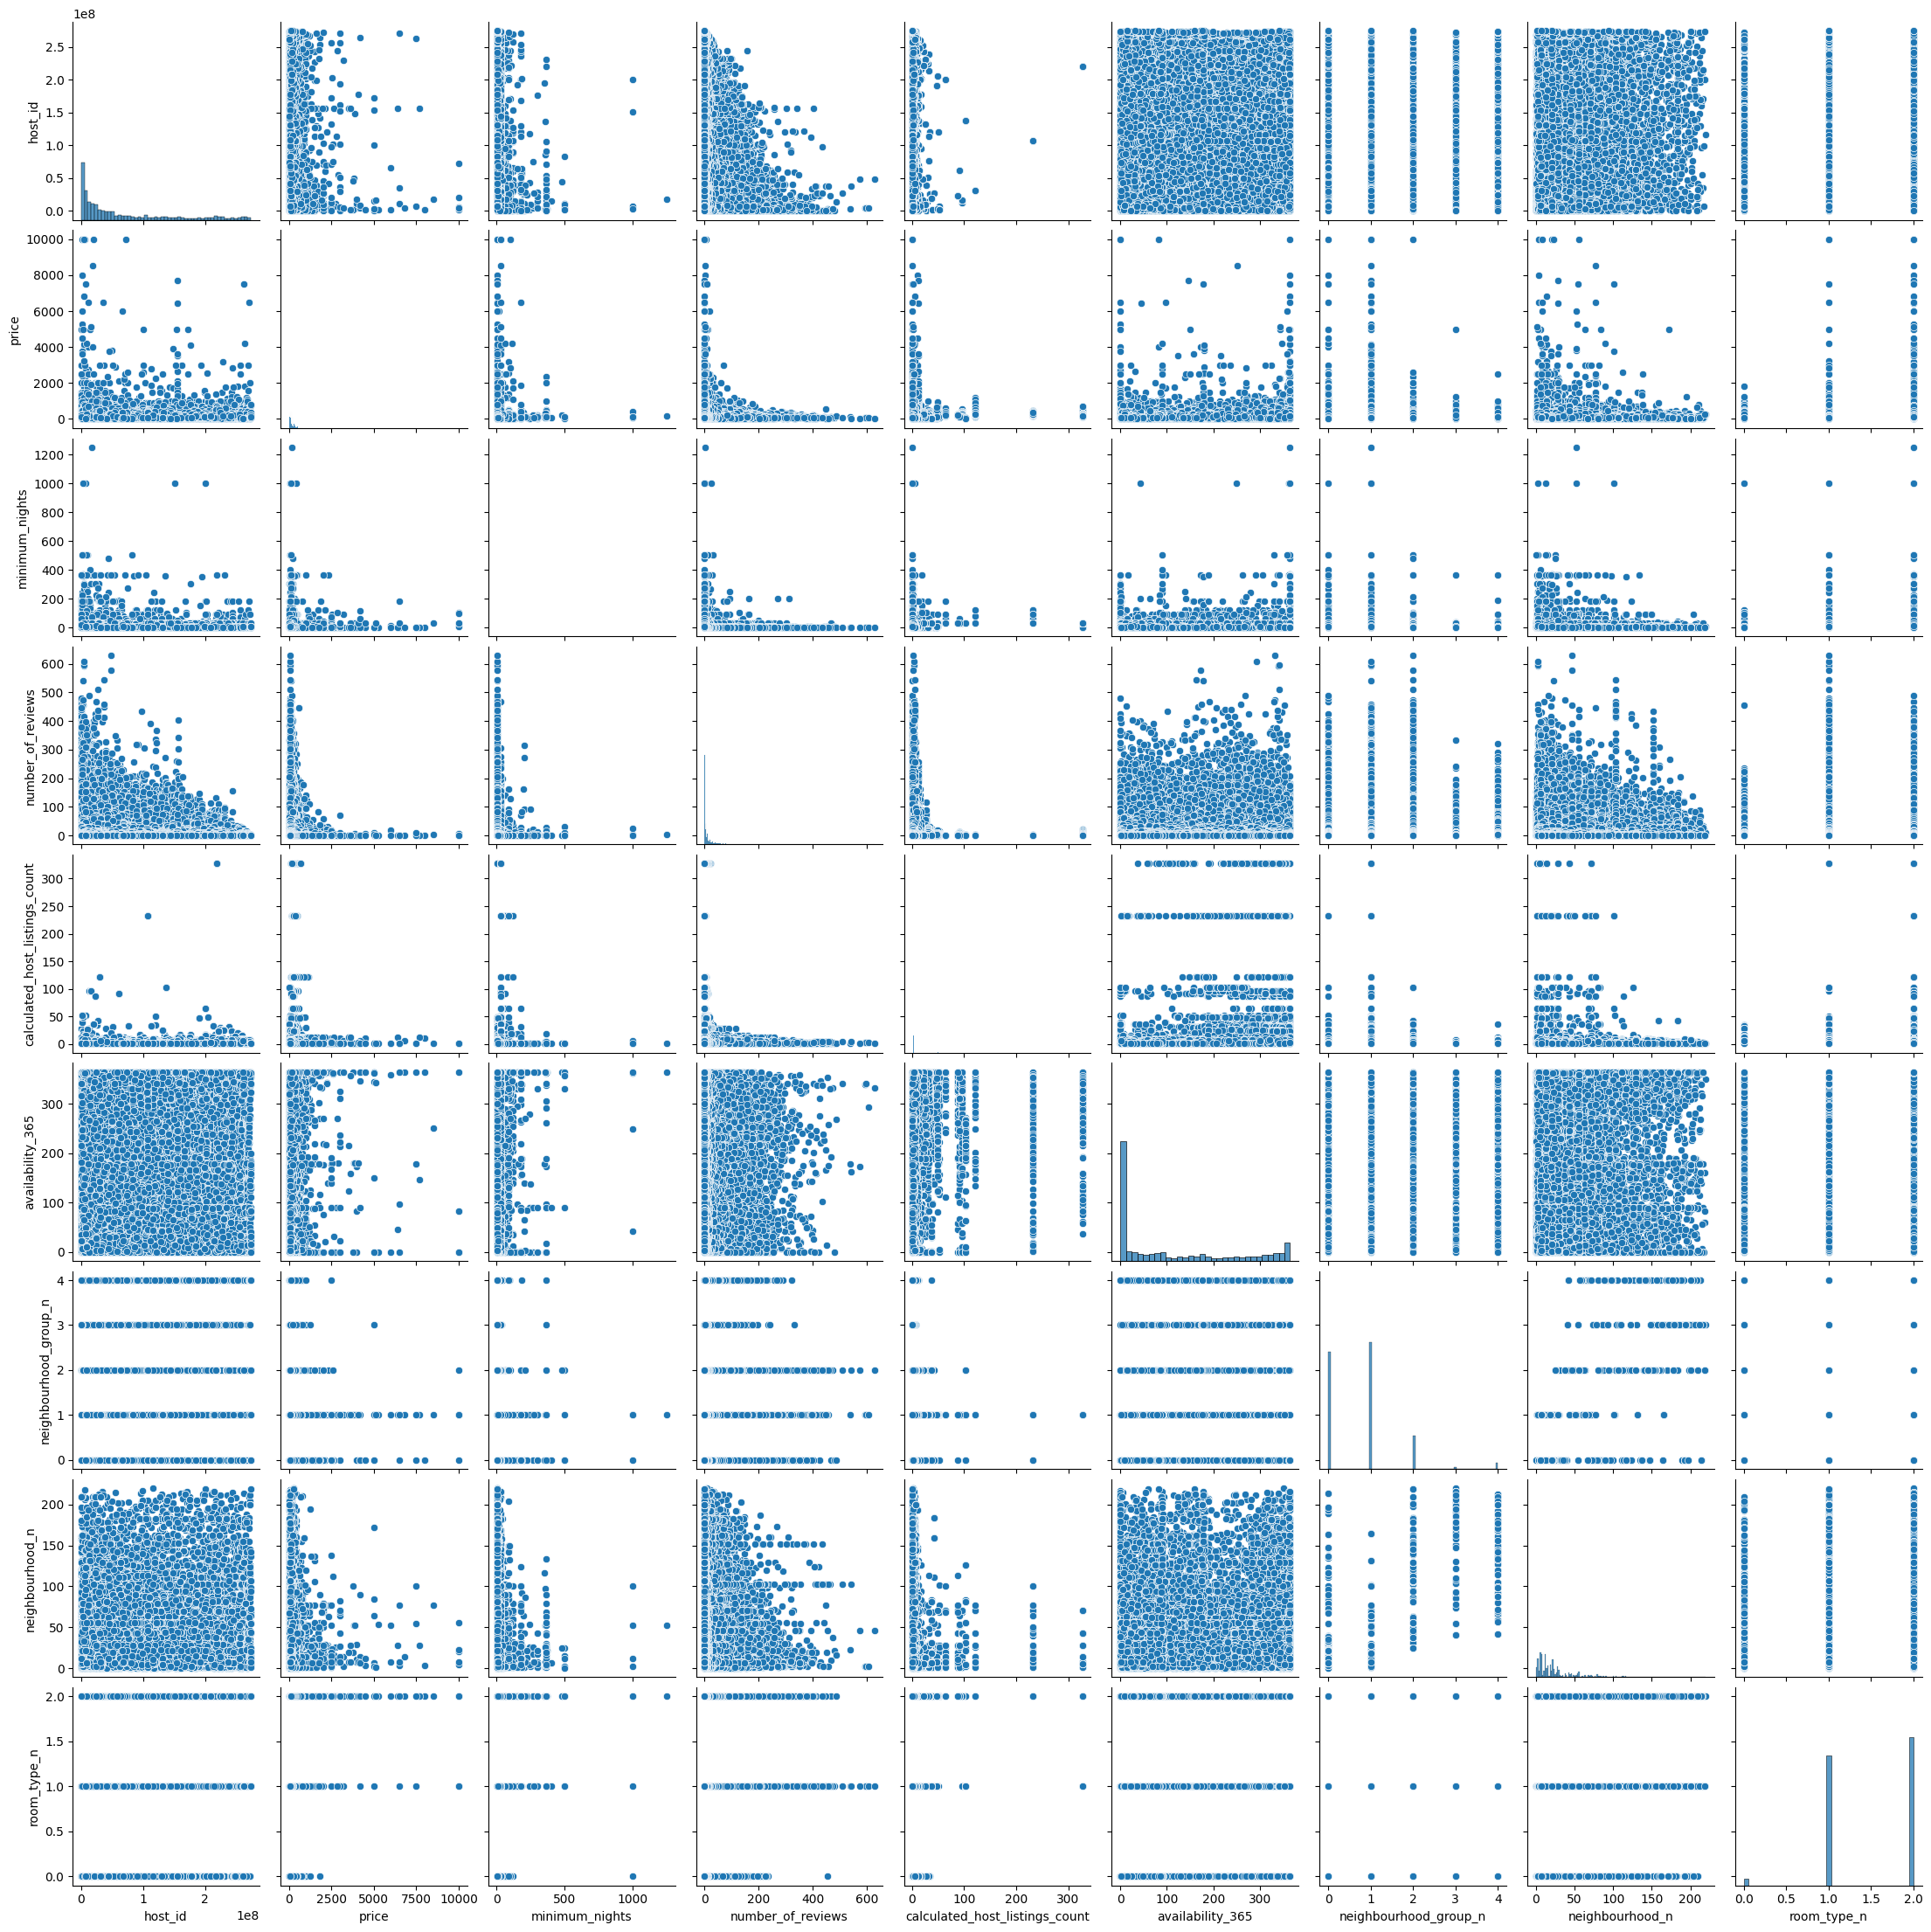

In [ ]:
sns.pairplot(data=raw_data)

### Day 2 exercises


In [ ]:
raw_data.describe()

,host_id,price,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group_n,neighbourhood_n,room_type_n
count,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000
mean,6.762001e+07,152.720687,7.029962,23.274466,7.143982,112.781327,0.786911,29.888782,1.495940
std,7.861097e+07,240.154170,20.510550,44.550582,32.952519,131.622289,0.844386,34.676634,0.545379
min,2.438000e+03,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,7.822033e+06,69.000000,1.000000,1.000000,1.000000,0.000000,0.000000,7.500000,1.000000
50%,3.079382e+07,106.000000,3.000000,5.000000,1.000000,45.000000,1.000000,19.000000,2.000000
75%,1.074344e+08,175.000000,5.000000,24.000000,2.000000,227.000000,1.000000,37.000000,2.000000
max,2.743213e+08,10000.000000,1250.000000,629.000000,327.000000,365.000000,4.000000,220.000000,2.000000


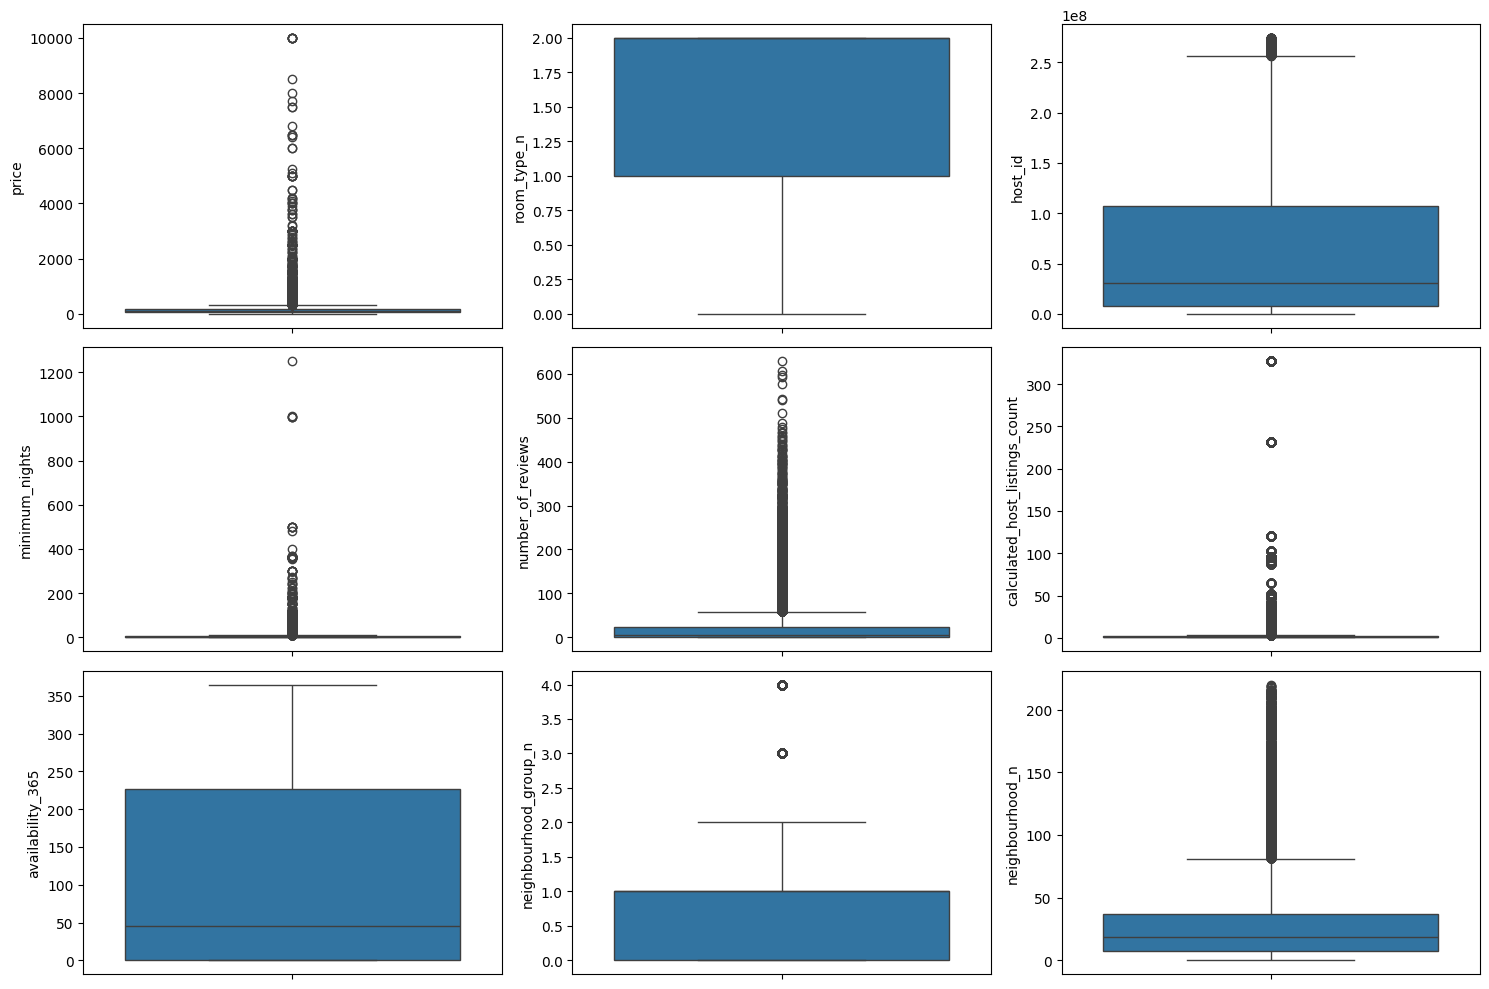

In [ ]:
fig, axis = plt.subplots(3, 3, figsize=(15, 10))

sns.boxplot(ax=axis[0, 0], data=raw_data, y="price")
sns.boxplot(ax=axis[0, 1], data=raw_data, y="room_type_n")
sns.boxplot(ax=axis[0, 2], data=raw_data, y="host_id")
sns.boxplot(ax=axis[1, 0], data=raw_data, y="minimum_nights")
sns.boxplot(ax=axis[1, 1], data=raw_data, y="number_of_reviews")
sns.boxplot(ax=axis[1, 2], data=raw_data, y="calculated_host_listings_count")
sns.boxplot(ax=axis[2, 0], data=raw_data, y="availability_365")
sns.boxplot(ax=axis[2, 1], data=raw_data, y="neighbourhood_group_n")
sns.boxplot(ax=axis[2, 2], data=raw_data, y="neighbourhood_n")

plt.tight_layout()

plt.show()

Items affected by outliers: price, minimum_nights, number_of_reviews, calculated_host_listings_count, neighbourhood_group, neighbourhood.

Maintain-eliminate-replace decisions: Most of these I'd keep.  The first exception is that I'd recommend eliminating rows for which minimum_nights is >1 or >2 years.  At that point landlords are using AirBnB to effectively sublet out a whole-year or multi-year rental property to a tenant, which seems like a different-enough business model vs. BnB that it's no longer an apples-to-apples comparison.

On talking about this more with a classmate he convinced me it's worth treating some of the higher-priced units as outliers, so I picked a threshold for that to remove those, too.

In [ ]:
print(raw_data["minimum_nights"].describe())
outlier_threshold_in_days = 365
long_stays = raw_data.query(f"minimum_nights > {outlier_threshold_in_days}")
print(long_stays)
raw_data = raw_data.query(
    f"minimum_nights <= {outlier_threshold_in_days}"
)  # to drop the outlier rows

count    48895.000000
mean         7.029962
std         20.510550
min          1.000000
25%          1.000000
50%          3.000000
75%          5.000000
max       1250.000000
Name: minimum_nights, dtype: float64
         host_id neighbourhood_group       neighbourhood        room_type  \
1305     2798644            Brooklyn            Bushwick  Entire home/apt   
2854     6676776           Manhattan   Battery Park City  Entire home/apt   
5767    17550546           Manhattan   Greenwich Village  Entire home/apt   
7355     3680008              Queens    Long Island City  Entire home/apt   
8014    10720264           Manhattan              Harlem  Entire home/apt   
10829   43945071              Queens    Long Island City  Entire home/apt   
11193    8996336            Brooklyn       Crown Heights     Private room   
13404    2697686           Manhattan              Harlem  Entire home/apt   
14285    2228137            Brooklyn          Kensington     Private room   
15946   16476167 

In [ ]:
print(raw_data["price"].describe())
outlier_thrshold_price = 6000
expensive_places = raw_data.query(f"price > {outlier_thrshold_price}")
print(expensive_places)
raw_data = raw_data.query(
    f"price <= {outlier_thrshold_price}"
)  # to drop the outlier rows

count    48875.000000
mean       151.516215
std        213.987115
min          0.000000
25%         69.000000
50%        106.000000
75%        175.000000
max       8500.000000
Name: price, dtype: float64
         host_id neighbourhood_group      neighbourhood        room_type  \
3774    11598359            Brooklyn       Clinton Hill  Entire home/apt   
4377     1177497            Brooklyn       Clinton Hill  Entire home/apt   
29662  156158778           Manhattan    Upper East Side  Entire home/apt   
29664  156158778           Manhattan    Upper East Side  Entire home/apt   
30268   18128455           Manhattan            Tribeca  Entire home/apt   
37194   35303743           Manhattan    Upper West Side     Private room   
42523    7407743           Manhattan  Battery Park City  Entire home/apt   
44034    3750764           Manhattan            Chelsea  Entire home/apt   
45666  262534951            Brooklyn      East Flatbush     Private room   
48043  271248669           Manhattan

#### Feature scaling
##### Splitting training vs test data

In [ ]:
from sklearn.model_selection import train_test_split

num_variables = [
    "room_type_n",
    "host_id",
    "minimum_nights",
    "number_of_reviews",
    "calculated_host_listings_count",
    "availability_365",
    "neighbourhood_group_n",
    "neighbourhood_n",
]


# We divide the dataset into training and test samples
X = raw_data.drop("price", axis=1)[num_variables]
y = raw_data["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train.head()

,room_type_n,host_id,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group_n,neighbourhood_n
4162,1,13795689,2,24,1,318,1,30
45906,2,221200420,30,0,23,311,1,5
24179,1,136646834,2,19,1,0,1,30
37892,2,12211018,2,3,1,0,0,3
40069,2,6096884,3,4,1,87,1,27


In [ ]:
# normalization scaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_train_norm = pd.DataFrame(X_train_norm, index=X_train.index, columns=num_variables)

X_test_norm = scaler.transform(X_test)
X_test_norm = pd.DataFrame(X_test_norm, index=X_test.index, columns=num_variables)

X_train_norm.head()

,room_type_n,host_id,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group_n,neighbourhood_n
4162,-0.910919,-0.684950,-0.294568,0.012900,-0.187651,1.563750,0.248831,-0.000903
45906,0.922925,1.954619,1.401318,-0.523392,0.476839,1.510461,0.248831,-0.718295
24179,-0.910919,0.878535,-0.294568,-0.098827,-0.187651,-0.857081,0.248831,-0.000903
37892,0.922925,-0.705117,-0.294568,-0.456356,-0.187651,-0.857081,-0.930906,-0.775687
40069,0.922925,-0.782930,-0.234001,-0.434010,-0.187651,-0.194778,0.248831,-0.086990


In [ ]:
# min-max scaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scal = scaler.transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, index=X_train.index, columns=num_variables)

X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, index=X_test.index, columns=num_variables)

X_train_scal.head()

,room_type_n,host_id,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,neighbourhood_group_n,neighbourhood_n
4162,0.5,0.050282,0.002747,0.038156,0.000000,0.871233,0.25,0.136986
45906,1.0,0.806353,0.079670,0.000000,0.067485,0.852055,0.25,0.022831
24179,0.5,0.498122,0.002747,0.030207,0.000000,0.000000,0.25,0.136986
37892,1.0,0.044505,0.002747,0.004769,0.000000,0.000000,0.00,0.013699
40069,1.0,0.022217,0.005495,0.006359,0.000000,0.238356,0.25,0.123288


In [ ]:
# feature selection for selecting most-relevant features to use for building ML model

from sklearn.feature_selection import f_classif, SelectKBest

# With a value of k = 5 we implicitly mean that we want to remove 3 features from the 8-column dataset
selection_model = SelectKBest(f_classif, k=5)
selection_model.fit(X_train_scal, y_train)
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(
    selection_model.transform(X_train), columns=X_train.columns.values[ix]
)
X_test_sel = pd.DataFrame(
    selection_model.transform(X_test), columns=X_test.columns.values[ix]
)

X_train_sel.head()

,room_type_n,minimum_nights,calculated_host_listings_count,availability_365,neighbourhood_n
0,1,2,1,318,30
1,2,30,23,311,5
2,1,2,1,0,30
3,2,2,1,0,3
4,2,3,1,87,27


In [ ]:
X_train_sel["price"] = list(y_train)
X_test_sel["price"] = list(y_test)

In [ ]:
X_train_sel.to_csv(
    "../data/interim/clean_nyc_airbnb_train.csv",
    index=False,
)
X_test_sel.to_csv("../data/interim/clean_nyc_airbnb_test.csv", index=False)